# Support Vector Machines

In [2]:
%matplotlib inline

import cvxopt
from cvxopt.base import matrix
from cvxopt.solvers import qp

import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
import random, math

### Configuration

In [3]:
# Configuration
RANDOM_SEED = 999
cvxopt.solvers.options['show_progress'] = False
ALPHA_THRESH = 1e-5
rcParams['figure.figsize'] = 20, 5

### Random data generation

In [4]:
# Data utils
def genData(num, boundsA, boundsB, rng):
    data = []
    random.seed(RANDOM_SEED)
    data += [(random.normalvariate(boundsA[0], rng), random.normalvariate(boundsA[1], rng), +1.0) for _ in range(num//2)]
    data += [(random.normalvariate(boundsB[0], rng), random.normalvariate(boundsB[1], rng) , -1.0) for _ in range(num//2)]
    random.shuffle(data)
    return data

## Linear Solver

In [5]:
# QP Solver
def build_P(data, kernel, **args):
    N = len(data)
    P = np.ndarray(shape=(N, N))
    x = [p[:-1] for p in data]
    t = [p[-1] for p in data]
    for i in range(N):
        for j in range(N):
            P[i][j] = t[i]*t[j]*kernel(x[i], x[j], **args)
    return P

def build_q(data):
    return -1*np.ones(len(data))

def build_G(data):
    return -1*np.eye(len(data))

def build_h(data):
    return np.zeros(len(data))

def indicator(xnew, data, alpha, kernel, **args):
    N = len(alpha)
    t = [p[-1] for p in data]
    x = [p[:-1] for p in data]
    ind = sum(alpha[i]*t[i]*kernel(xnew, x[i], **args) for i in alpha.keys())
    return ind

def build_alpha(r, threshhold):
    raw_alpha = list(r['x'])
    alpha = {}
    for i in range(len(raw_alpha)):
        if raw_alpha[i] > ALPHA_THRESH:
            alpha[i] = raw_alpha[i]
    return alpha

def runQP(num, boundsA, boundsB, rng, kernel, **args):
    data = genData(num, boundsA, boundsB, rng)
    P, q, G, h = build_P(data, kernel, **args), build_q(data), build_G(data), build_h(data)
    r = qp(P=matrix(P), q=matrix(q), G=matrix(G), h=matrix(h), kktsolver='ldl')
    alpha = build_alpha(r, threshhold=ALPHA_THRESH)
    return data, alpha

### Plotting utilities

In [6]:
# Plot utils
def plotBoundary(data, alpha, kernel, **args):
    xrange = np.arange(-4, 4, 0.05)
    yrange = np.arange(-4, 4, 0.05)
    inds = [[indicator((x, y), data, alpha, kernel, **args) for x in xrange] for y in yrange]
    plt.contour(xrange, yrange, inds, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

def plotPoints(data, alpha, title):
    dataA = list(filter(lambda p: p[-1] == +1.0, data))
    dataB = list(filter(lambda p: p[-1] == -1.0, data))
    suppv = [s for i,s in enumerate(data) if i in alpha.keys()]
    plt.title(title)
    plt.plot([p[0] for p in dataA], [p[1] for p in dataA], 'bo')
    plt.plot([p[0] for p in dataB], [p[1] for p in dataB], 'ro')
    plt.plot([p[0] for p in suppv], [p[1] for p in suppv], 'wx')
    
def plotAll(data, alpha, title, kernel, **args):
    plotPoints(data, alpha, title)
    plotBoundary(data, alpha, kernel, **args)

# Linear Kernel

In [7]:
def kernelLinear(x, y):
    return np.dot(x, y) + 1

In [8]:
plt.subplot(121)
data, alpha = runQP(num=30, boundsA=(-1.5, 0.5), boundsB=(0.0, -0.5), rng=0.5, kernel=kernelLinear)
plotAll(data, alpha, title='Easy dataset (range=0.5)', kernel=kernelLinear)

plt.subplot(122)
data, alpha = runQP(num=30, boundsA=(-1.5, 0.5), boundsB=(0.0, -0.5), rng=1.75, kernel=kernelLinear)
plotAll(data, alpha, title='Hard dataset (range=1.5)', kernel=kernelLinear)

### Linear kernels fail as soon as dataset is a bit harder to separate
#### We can also see the support vectors as the crossed points in the graph

# Non-linear Kernels

## Polynomial Kernels

In [9]:
def kernelPolynomial(x, y, p):
    return (np.dot(x, y) + 1)**p

In [10]:
num = 1
for p in [2, 3, 4]:
    sub = 130 + num
    plt.subplot(sub)
    data, alpha = runQP(num=30, boundsA=(-1.5, 0.5), boundsB=(0.0, -0.5), rng=1.4, kernel=kernelPolynomial, p=p)
    plotAll(data, alpha, f'Polynomial Kernel (p={p})', kernelPolynomial, p=p)
    num += 1

### A higher degree produces more *complex shapes* but may *generalise less* depending on the dataset.
#### Especially if we have a small dataset as models need to be as simple as possible

## Radial Kernels

In [11]:
def kernelRadial(x, y, sigma):
    x_y = np.array(x) - np.array(y)
    x_y_2 = np.dot(x_y, x_y)
    return np.exp(-x_y_2/(2*sigma**2))

In [12]:
num = 1
for sigma in [0.5, 1, 2]:
    sub = 130 + num
    plt.subplot(sub)
    data, alpha = runQP(num=30, boundsA=(-1.5, 0.5), boundsB=(0.0, -0.5), rng=1.4, kernel=kernelRadial, sigma=sigma)
    plotAll(data, alpha, f'Radial Kernel (σ={sigma})', kernelRadial, sigma=sigma)
    num += 1

### When sigma grows, the models generate smoother curves
#### It may be able to generalise better for new data as more bias and less variance can be better

## Sigmoid Kernels

In [13]:
def kernelSigmoid(x, y, k, lamb):
    return np.tanh(k*np.dot(x, y)-lamb)

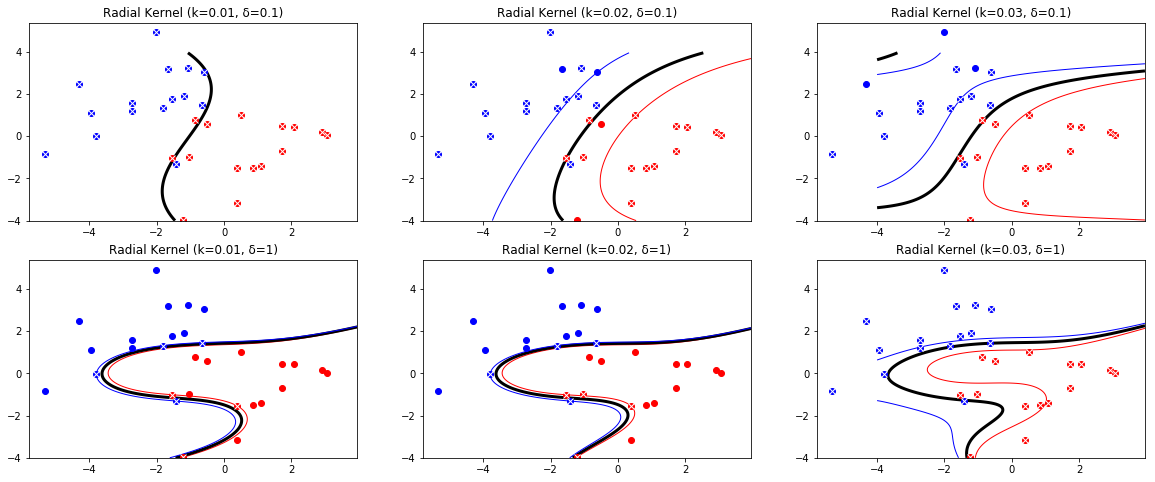

In [14]:
rcParams['figure.figsize'] = 20, 8
 
num = 1
for lamb in [0.1, 1]:
    for k in [0.01, 0.02, 0.03]:
        sub = 230 + num
        plt.subplot(sub)
        data, alpha = runQP(num=30, boundsA=(-1.5, 0.5), boundsB=(0.0, -0.5), rng=1.7, kernel=kernelSigmoid, k=k, lamb=lamb)
        plotAll(data, alpha, f'Radial Kernel (k={k}, δ={lamb})', kernelSigmoid, k=k, lamb=lamb)
        num += 1
        
rcParams['figure.figsize'] = 20, 5

### Parameters k and lambda influence the complexity of the shapes as they grow

## Slack Implementation

In [62]:
def runQPSlack(num, boundsA, boundsB, rng, C, kernel, **args):
    data = genData(num, boundsA, boundsB, rng)
    P, q, G, h = build_P(data, kernel, **args), build_q(data), build_G(data), build_h(data)
    h = np.append(h, C*np.ones(len(h)), axis=0)
    G = np.append(G, -G, axis=0)
    r = qp(P=matrix(P), q=matrix(q), G=matrix(G), h=matrix(h))
    alpha = build_alpha(r, threshhold=ALPHA_THRESH)
    return data, alpha

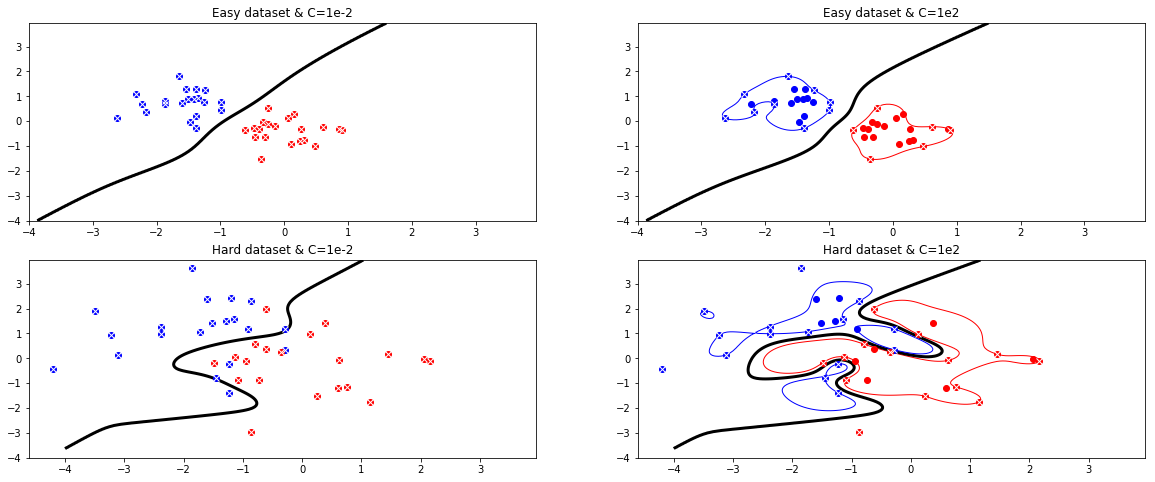

In [63]:
rcParams['figure.figsize'] = 20, 8

num = 1
for rng_lbl,rng in {'Easy': 0.5, 'Hard': 1.2}.items():
    for C_lbl, C in {'1e-2': 1e-2, '1e2': 1e2}.items():
        sub = 220 + num
        plt.subplot(sub)
        data, alpha = runQPSlack(num=40, boundsA=(-1.5, 0.5), boundsB=(0.0, -0.5), rng=rng, C=C, kernel=kernelRadial, sigma=0.5)
        plotAll(data, alpha, f'{rng_lbl} dataset & C={C_lbl}', kernel=kernelRadial, sigma=0.5)
        num += 1
        
rcParams['figure.figsize'] = 20, 5

### Very large C values lead to less slack, smaller ones increase margin of error for classification
#### In real datasets, there is error and noise: introducing a slack variable can thus reduce the change of overfitting